In [206]:
######## SUPPORT VECTOR REGRESSION MODEL  ########

# De code bestaat uit verschillende onderdelen:

# 1. Preparing data 
#    Het uitlezen experiment data, berekenen mol. descriptors, transformeren EC50 value, scaffolds berekenen en een label meegeven voor groepen reaccuring scaffolds
#    Input: Desired experiment number, CTRPv2 Data Curves Post Quality check & CTRPv2 Meta per compound
#    Output: Data final summery per experiment ID & Data Scaffold Split per experminent ID

In [207]:
######## PREPARING DATA  ########

In [208]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as nm
import pandas as pd
import math
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict


In [209]:
# Import online Data Frame
folder = 'C:\\Users\\vswen\\Documents\\1. Biomedische Technologie\\BMT JAAR 5\\Kwart 4\\4. Data\\CTRPv2.0_2015_ctd2_ExpandedDataset\\'
experiment_id = 260


# Dataframe met kernwaarden aanmaken
df_large = pd.read_csv(f"{folder}v20.data.curves_post_qc.txt", sep='\t')
df_smiles = pd.read_csv(f"{folder}v20.meta.per_compound.txt", sep='\t')

df_large=df_large[df_large['experiment_id'] == experiment_id]
df_summary = df_large[[ 'master_cpd_id','apparent_ec50_umol']]
extracted_col = df_smiles[["master_cpd_id","cpd_smiles"]]
df_summary_sorted = pd.merge(df_summary, extracted_col, on='master_cpd_id', how='left')

def mol_descriptor(smiles: list, scale: bool = True) -> nm.ndarray:
    X = []
    for smi in tqdm(smiles):
        m = Chem.MolFromSmiles(smi)
        x = nm.array([Descriptors.TPSA(m),
                      Descriptors.MolLogP(m),
                      Descriptors.MolWt(m),
                      Descriptors.FpDensityMorgan2(m),
                      Descriptors.HeavyAtomMolWt(m),
                      Descriptors.MaxPartialCharge(m),
                      Descriptors.MinPartialCharge(m),
                      Descriptors.NumRadicalElectrons(m),
                      Descriptors.NumValenceElectrons(m),
                      rdMolDescriptors.CalcFractionCSP3(m),
                      rdMolDescriptors.CalcNumRings(m),
                      rdMolDescriptors.CalcNumRotatableBonds(m),
                      rdMolDescriptors.CalcNumLipinskiHBD(m),
                      rdMolDescriptors.CalcNumLipinskiHBA(m),
                      rdMolDescriptors.CalcNumHeterocycles(m),
                      rdMolDescriptors.CalcNumHeavyAtoms(m),
                      rdMolDescriptors.CalcNumAromaticRings(m),
                      rdMolDescriptors.CalcNumAtoms(m),
                      qed(m)])
        X.append(x)

    if scale:
        return pre.MinMaxScaler().fit_transform(nm.array(X))

    return nm.array(X)


# Dataframe met mol descriptors
smiles_column = df_summary_sorted['cpd_smiles']
descriptors = mol_descriptor(smiles_column)

df_summary_sorted[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']] = descriptors


df_summary_sorted['ec50_mol'] = df_summary_sorted['apparent_ec50_umol'] / 1000000
df_summary_sorted['ec50_mol']=df_summary_sorted['ec50_mol'].replace(0, 1e-10)
df_summary_sorted['ec50_molair'] = df_summary_sorted['ec50_mol']/ df_summary_sorted['MolWt']

df_summary_sorted.to_csv(f"{folder}v20.data.final_summary_{experiment_id}.txt", sep='\t', index=False)

100%|██████████| 452/452 [00:02<00:00, 167.79it/s]


In [210]:
# Making the scaffolds and forming scaffold based groups

In [211]:
df_complete = pd.read_csv(f"{folder}v20.data.final_summary_{experiment_id}.txt", sep='\t')
df_scaffold_split = df_complete[[ 'cpd_smiles','apparent_ec50_umol','MolWt','ec50_mol','ec50_molair']]

smiles_list = df_scaffold_split['cpd_smiles']
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
scaffolds = [MurckoScaffold.GetScaffoldForMol(mol) for mol in mols]
scaffold_smiles = [Chem.MolToSmiles(scaffold) for scaffold in scaffolds]
print(df_scaffold_split.head())

scaffold_smiles = list(map(str, scaffold_smiles))

# Fingerprint aanmaken
molecule_scaffold = [Chem.MolFromSmiles(smile) for smile in scaffold_smiles]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024) for molecule in molecule_scaffold]

def get_unique_scaffolds(scaffold_smiles):
    unique_scaffolds = []
    for scaffold in scaffold_smiles:
        if scaffold not in unique_scaffolds:
            unique_scaffolds.append(scaffold)
    return unique_scaffolds

list_unique_scaffolds=get_unique_scaffolds(scaffold_smiles)

location_scaffolds = defaultdict(list)
for scaffold in scaffold_smiles:
    location_scaffolds[scaffold].append(scaffold)
print("similar grouped dictionary : " + str(dict(location_scaffolds)))

def location_similar_scaffolds(lijst):
    locations = defaultdict(list)
    for index, item in enumerate(lijst):
        if lijst.count(item) > 1:
            locations[item].append(index)
    return dict(locations)

locations_similar_scaffolds = location_similar_scaffolds(scaffold_smiles)
print(locations_similar_scaffolds)

df_scaffolds_grouped = pd.DataFrame(columns=['Compound', 'Scaffold', 'Recurring'])
rows=[]
symbol_mapping = {}  # Scaffold symbool dictionary
symbol_counter = 0  # Aantal unieke scaffolds

symbol_counter = 0
symbol_mapping = {}
rows = []

for i, compound in enumerate(smiles_list):
    scaffold = scaffold_smiles[i]

    if scaffold in locations_similar_scaffolds:
        if scaffold not in symbol_mapping:
            symbol_counter += 1
            symbol_mapping[scaffold] = symbol_counter

        recurring_symbol = symbol_mapping[scaffold]
        recurring = True
    else:
        recurring_symbol = 0
        recurring = False
    row = [compound, scaffold, recurring_symbol]
    rows.append(row)

df_scaffolds_grouped = pd.DataFrame(rows, columns=['cpd_smiles', 'spd_scaffold', 'recurring_scaffold'])

#Toevoegen van extra data die nodig is voor de modellen
df_scaffolds_grouped.insert(0,'ec50_molair',df_scaffold_split['ec50_molair'])
df_scaffolds_grouped.insert(1,'MolWt',df_scaffold_split['MolWt'])

df_scaffolds_grouped_sorted = df_scaffolds_grouped.sort_values('recurring_scaffold', ascending=False)

df_scaffolds_grouped_sorted.to_csv(f"{folder}scaffold_split_{experiment_id}.txt", sep='\t', index=False)

                                          cpd_smiles  apparent_ec50_umol  \
0              CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1               7.166   
1  CC(C)N1C(=O)S\C(=C\c2ccc(Sc3nc4ccccc4[nH]3)o2)...               9.979   
2            C(Cn1c2ccccc2c2ccccc12)c1nc2ccccc2[nH]1              18.350   
3           C1CN(CCO1)c1nnc(-c2ccccc2)c(n1)-c1ccccc1             107.700   
4                   CC(C)(C)c1ccc2cc(C#N)c(cc2c1)C#N               8.735   

      MolWt  ec50_mol  ec50_molair  
0  0.076117  0.000007     0.000094  
1  0.087238  0.000010     0.000114  
2  0.061933  0.000018     0.000296  
3  0.064321  0.000108     0.001674  
4  0.035601  0.000009     0.000245  
similar grouped dictionary : {'c1ccc2c(c1)SCc1ccsc1-2': ['c1ccc2c(c1)SCc1ccsc1-2', 'c1ccc2c(c1)SCc1ccsc1-2'], 'O=C1NC(=O)/C(=C\\c2ccc(Sc3nc4ccccc4[nH]3)o2)S1': ['O=C1NC(=O)/C(=C\\c2ccc(Sc3nc4ccccc4[nH]3)o2)S1'], 'c1ccc2[nH]c(CCn3c4ccccc4c4ccccc43)nc2c1': ['c1ccc2[nH]c(CCn3c4ccccc4c4ccccc43)nc2c1'], 'c1ccc(-c2nnc(N3CCOCC

In [212]:

######## SCAFFOLD SPLIT SUPPORT VECTOR REGRESSION  ########


In [213]:
# Import data
complete_df = pd.read_csv(f"{folder}scaffold_split_{experiment_id}.txt", sep="\t")

In [214]:
# Fingerprint aanmaken
## Morgan Fingerprint ECFP
molecules = [Chem.MolFromSmiles(smile) for smile in complete_df['cpd_smiles'].tolist()]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule,2,nBits=1024) for molecule in molecules]
complete_df['ecfp_bit_vectors'] = [[int(bit) for bit in keys.ToBitString()] for keys in ecfp]
complete_df['ECFP'] = [''.join(str(value) for value in row) for row in complete_df['ecfp_bit_vectors']]

In [215]:
# Transformatie EC50 | Instellen van limiten
complete_df['ec50_molair_transformed'] = -nm.log10(complete_df['ec50_molair'])
condition = (complete_df['ec50_molair_transformed'] < 2 ) | (complete_df['ec50_molair_transformed'] > 8)
complete_df=complete_df[~condition]

In [216]:
# Train- Test verhoudingen totale dataframe
total_length_compounds = len(complete_df)
size_train_set = total_length_compounds * 0.8 

In [217]:
# Scaffold Split | Unieke scaffolds

# Plaats Unieke Scaffolds in aparte dataframe
df_unique_scaffolds = complete_df[complete_df['recurring_scaffold'] == 0]
df_unique_scaffolds = df_unique_scaffolds[['recurring_scaffold', 'ecfp_bit_vectors', 'ec50_molair_transformed']]

# Extraheer de X en Y value van de nieuwe DF 
x_unique = nm.array(df_unique_scaffolds['ecfp_bit_vectors'].tolist()) ## X is de te gebruike compound waarde  | Fingerprint ECFP
y_unique = df_unique_scaffolds['ec50_molair_transformed'].values ## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed

In [218]:
# Scaffold Split | Repeterende scaffolds

# Plaats Repeterende Scaffolds in een aparte dataframe
df_grouped_scaffolds = complete_df[complete_df['recurring_scaffold'] > 0]
df_grouped_scaffolds = df_grouped_scaffolds[['ecfp_bit_vectors', 'ec50_molair_transformed', 'recurring_scaffold']]

# Extraheer de X, Y en Z value van de nieuwe DF 
x_grouped = nm.array(df_grouped_scaffolds['ecfp_bit_vectors'].tolist()) ## X is de te gebruike compound waarde  | Fingerprint ECFP
y_grouped = df_grouped_scaffolds['ec50_molair_transformed'].values ## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
z_grouped = df_grouped_scaffolds['recurring_scaffold'].values.tolist() ## Z is de indicator voor overeenkomstige scaffold groepen | Elke scaffoldgroup 

In [219]:
# Scaffold Split | Train- Test verhoudingen repeterende scaffolds dataframe

size_train_set_grouped_scaffolds = len(z_grouped) * 0.8
size_train_set_grouped_scaffolds = int(size_train_set_grouped_scaffolds)

In [220]:
# Scaffold Split | Train- Test repeterende scaffolds

# Lijsten voor repeterende scaffold verdeling
x_train_grouped = []
y_train_grouped = []
x_test_grouped = []
y_test_grouped = []

# Verdeling moleculen op basis van scaffold groepen
for x in range(len(z_grouped)):
    if x < size_train_set_grouped_scaffolds:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    elif z_grouped[x] == z_grouped[x-1]:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    else: 
        remaining = len(z_grouped)-x
        break
        
for x in range(remaining):
    x_test_grouped.append(x_grouped[x+remaining])
    y_test_grouped.append(y_grouped[x+remaining])

# X values omzetten in juiste vorm
x_train_grouped = [list(arr) for arr in x_train_grouped]
x_test_grouped = [list(arr) for arr in x_test_grouped]

# Indicatie resulterende lijsten
print('The length of the x_train list with grouped scaffolds is', len(x_train_grouped))
print('The length of the x_test list with grouped scaffolds is', len(x_test_grouped))
print('\nFirst five values of y_train with grouped scaffolds:\n', y_train_grouped[0:5])
print('\nFirst five values of y_test with grouped scaffolds:\n',y_test_grouped[0:5])

The length of the x_train list with grouped scaffolds is 46
The length of the x_test list with grouped scaffolds is 11

First five values of y_train with grouped scaffolds:
 [5.281975051615411, 2.903063738077735, 4.510405057314544, 4.632695934542562, 3.5110941709698023]

First five values of y_test with grouped scaffolds:
 [7.54533204461795, 5.620617975684917, 3.803432990320223, 4.199128578069801, 6.4995694251816785]


In [221]:
# Scaffold Split | Train- Test unieke scaffolds

# Random verdeling van unieke scaffolds
from sklearn.model_selection import train_test_split
x_train_unique,x_test_unique,y_train_unique,y_test_unique=train_test_split(x_unique,y_unique,test_size=0.2, random_state=42)

# X values omzetten in juiste vorm
x_train_unique = [list(arr) for arr in x_train_unique]
x_test_unique = [list(arr) for arr in x_test_unique]

In [222]:
# Scaffold Split | Uiteindelijke Train- Tests vormen

# Samenvoegen van verdelingen unieke scaffolds en repeterende scaffolds
x_train_scaffolds = nm.concatenate((x_train_grouped, x_train_unique))
x_test_scaffolds = nm.concatenate((x_test_grouped, x_test_unique))

y_train_scaffolds = nm.concatenate((y_train_grouped, y_train_unique))
y_test_scaffolds = nm.concatenate((y_test_grouped, y_test_unique))

In [223]:
# Fit Regressor
model = SVR(C=1, epsilon=0.1, kernel='rbf')
model.fit(x_train_scaffolds,y_train_scaffolds)

# Predict Test result
y_pred_scaffolds  = model.predict(x_test_scaffolds)

In [224]:
# Errors berekenen
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error
mae=mean_absolute_error(y_test_scaffolds, y_pred_scaffolds)
print('mean absolute error is ', mae)

# Mean Squared Error
mse = mean_squared_error(y_test_scaffolds, y_pred_scaffolds)
print('mean squared error is ', mse)

# Root Mean Squared Error
rmse = math.sqrt(mse)
print('root mean squared error is ', rmse)

# R2 berekenen
slope, intercept = nm.polyfit(y_test_scaffolds,y_pred_scaffolds,1)
line = slope * nm.array(y_test_scaffolds)+ intercept
r2 = r2_score(y_test_scaffolds, y_pred_scaffolds)
print('r2 is', r2)

residuen_scaffold  = y_test_scaffolds - y_pred_scaffolds

mean absolute error is  0.8377960122186621
mean squared error is  1.1570167318609155
root mean squared error is  1.0756471223690953
r2 is 0.2732541811269317


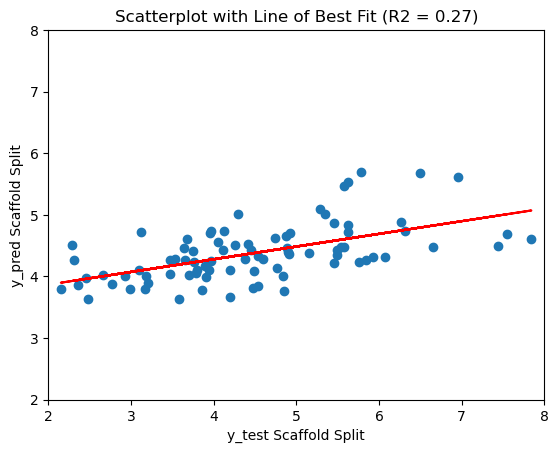

In [225]:
# R2 Visualisatie
plt.scatter(y_test_scaffolds,y_pred_scaffolds)
plt.plot(y_test_scaffolds, line, color='red', label='line of current best fit')
plt.xlabel('y_test Scaffold Split')
plt.ylabel('y_pred Scaffold Split')
plt.xlim(2,8)
plt.ylim(2,8)
plt.title('Scatterplot with Line of Best Fit (R2 = {:.2f})'.format(r2))
plt.show()

In [226]:

######## RANDOM SPLIT CODE  ########


root mean squared error is  0.899549283592018
r2 is 0.19842166219053514


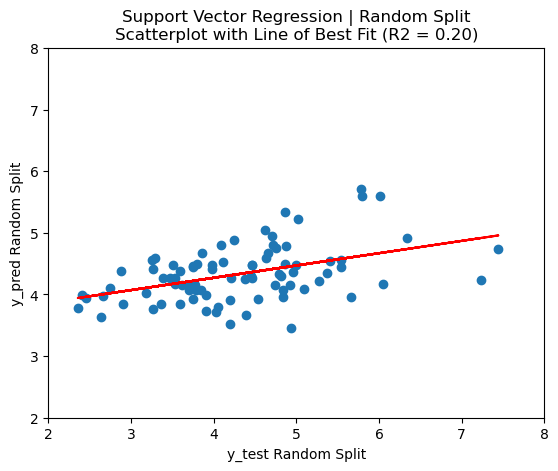

In [227]:
# Import data
complete_df = pd.read_csv(f"{folder}v20.data.final_summary_{experiment_id}.txt", sep="\t")

# Fingerprint aanmaken
## Morgan Fingerprint ECFP
molecules = [Chem.MolFromSmiles(smile) for smile in complete_df['cpd_smiles'].tolist()]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule,2,nBits=1024) for molecule in molecules]
complete_df['ecfp_bit_vectors'] = [[int(bit) for bit in keys.ToBitString()] for keys in ecfp]
complete_df['ECFP'] = [''.join(str(value) for value in row) for row in complete_df['ecfp_bit_vectors']]

# Transformatie EC50 | Instellen van limiten
complete_df['ec50_molair_transformed'] = -nm.log10(complete_df['ec50_molair'])
condition = (complete_df['ec50_molair_transformed'] < 2 ) | (complete_df['ec50_molair_transformed'] > 8)
complete_df=complete_df[~condition]

x_random = nm.array(complete_df['ecfp_bit_vectors'].tolist())
y_random = complete_df['ec50_molair_transformed'].values

# Split Test & Train
from sklearn.model_selection import train_test_split
x_train_random,x_test_random,y_train_random,y_test_random=train_test_split(x_random,y_random,test_size=0.2, random_state=42)

# SVR Model
model = SVR(C=1, epsilon=0.1, kernel='rbf')
model.fit(x_train_random,y_train_random)
y_pred_random  = model.predict(x_test_random)

# Errors berekenen
# Root Mean Squared Error
mse = mean_squared_error(y_test_random, y_pred_random)
rmse = math.sqrt(mse)
print('root mean squared error is ', rmse)

# R2 berekenen
slope, intercept = nm.polyfit(y_test_random,y_pred_random,1)
line = slope * nm.array(y_test_random)+ intercept
r2 = r2_score(y_test_random, y_pred_random)
print('r2 is', r2)

residuen_random  = y_test_random - y_pred_random

# Visualisatie resultaten

# R2 Visualisatie
plt.scatter(y_test_random,y_pred_random)
plt.plot(y_test_random, line, color='red', label='line of current best fit')
plt.xlabel('y_test Random Split')
plt.ylabel('y_pred Random Split')
plt.xlim(2,8)
plt.ylim(2,8)
plt.title('Support Vector Regression | Random Split\nScatterplot with Line of Best Fit (R2 = {:.2f})'.format(r2))
plt.show()



In [228]:

######## COMPARISON RANDOM SPLIT & SCAFFOLD SPLIT CODE  ########


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


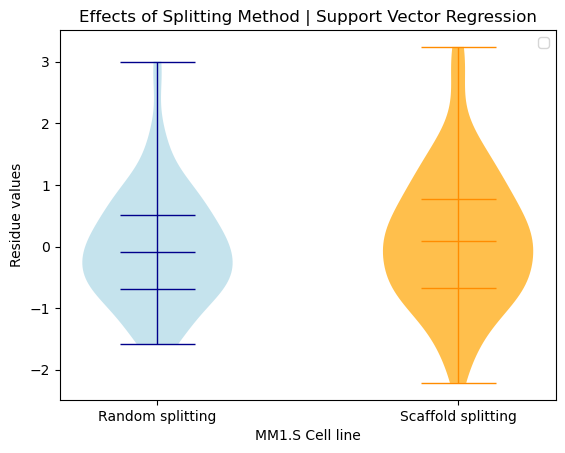

In [229]:
fig, ax = plt.subplots()

# Plot de violinplots voor beide modellen
parts_random = ax.violinplot(residuen_random, showmeans=False, quantiles=[0.25,0.5,0.75], showmedians=False, showextrema=True, positions=[0])
parts_scaffold = ax.violinplot(residuen_scaffold, showmeans=False, quantiles=[0.25,0.5,0.75], showmedians=False, showextrema=True, positions=[1])

# Aanpassen van de kleuren van de indicatoren
for pc in parts_random['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)

for pc in parts_scaffold['bodies']:
    pc.set_facecolor('orange')
    pc.set_alpha(0.7)

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp = parts_random[partname]
    vp.set_edgecolor("darkblue")
    vp.set_linewidth(1)
    vp2 = parts_scaffold[partname]
    vp2.set_edgecolor("darkorange")
    vp2.set_linewidth(1)

for partname in ('cquantiles',):
    vp = parts_random[partname]
    vp.set_edgecolor("darkblue")
    vp.set_linewidth(1)
    vp2 = parts_scaffold[partname]
    vp2.set_edgecolor("darkorange")
    vp2.set_linewidth(1)

# Opmaak van de plot
ax.set_xlabel('MM1.S Cell line')
ax.set_ylabel('Residue values')
ax.set_title('Effects of Splitting Method | Support Vector Regression')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Random splitting', 'Scaffold splitting'])


# Legenda tonen
ax.legend()

# Toon de plot
plt.show()

In [230]:

#### EXTENDED MOLECULAR DESCRIPTOR #####


In [231]:
# Import data
complete_df = pd.read_csv(f"{folder}scaffold_split_{experiment_id}.txt", sep="\t")

In [232]:
from tqdm.auto import tqdm
from rdkit.Chem.QED import qed
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn import preprocessing as pre
from typing import List

In [233]:
 # Fingerprint aanmaken
## Morgan Fingerprint ECFP
molecules = [Chem.MolFromSmiles(smile) for smile in complete_df['cpd_smiles'].tolist()]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule,2,nBits=1024) for molecule in molecules]
complete_df['ecfp_bit_vectors'] = [[int(bit) for bit in keys.ToBitString()] for keys in ecfp]
complete_df['ECFP'] = [''.join(str(value) for value in row) for row in complete_df['ecfp_bit_vectors']]

# Transformatie EC50 | Instellen van limiten
complete_df['ec50_molair_transformed'] = -nm.log10(complete_df['ec50_molair'])
condition = (complete_df['ec50_molair_transformed'] < 2 ) | (complete_df['ec50_molair_transformed'] > 8)
complete_df=complete_df[~condition]

In [234]:
def mol_descriptor(smiles: List[str], scale: bool = True) -> nm.ndarray:
    X = []
    for smi in tqdm(smiles):
        m = Chem.MolFromSmiles(smi)
        x = nm.array([Descriptors.TPSA(m),
                      Descriptors.MolLogP(m),
                      Descriptors.MolWt(m),
                      Descriptors.FpDensityMorgan2(m),
                      Descriptors.HeavyAtomMolWt(m),
                      Descriptors.MaxPartialCharge(m),
                      Descriptors.MinPartialCharge(m),
                      Descriptors.NumRadicalElectrons(m),
                      Descriptors.NumValenceElectrons(m),
                      rdMolDescriptors.CalcFractionCSP3(m),
                      rdMolDescriptors.CalcNumRings(m),
                      rdMolDescriptors.CalcNumRotatableBonds(m),
                      rdMolDescriptors.CalcNumLipinskiHBD(m),
                      rdMolDescriptors.CalcNumLipinskiHBA(m),
                      rdMolDescriptors.CalcNumHeterocycles(m),
                      rdMolDescriptors.CalcNumHeavyAtoms(m),
                      rdMolDescriptors.CalcNumAromaticRings(m),
                      rdMolDescriptors.CalcNumAtoms(m),
                      qed(m)])
        X.append(x)

    if scale:
        return pre.MinMaxScaler().fit_transform(nm.array(X))

    return nm.array(X)


smiles_column = complete_df['cpd_smiles']
descriptors = mol_descriptor(smiles_column)

complete_df[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']] = descriptors

total_descriptors = complete_df[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']]

list_of_descriptor_names = ['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']

total_descriptors.shape
complete_df.shape

  0%|          | 0/419 [00:00<?, ?it/s]

(419, 26)

root mean squared error is  1.0864353421120676
r2 is 0.16214983586457576


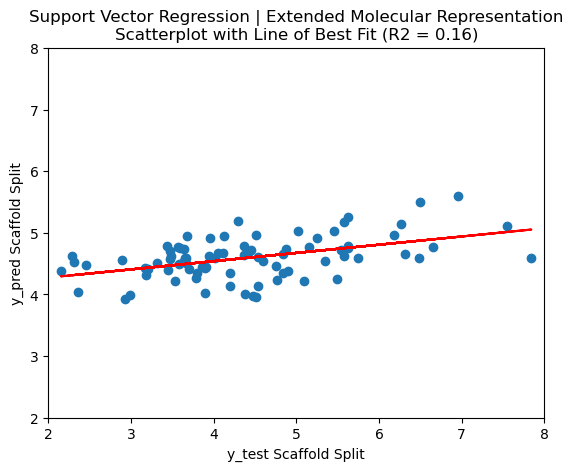

In [239]:
 # Plaats Unieke Scaffolds in aparte dataframe
df_unique_scaffolds = complete_df[complete_df['recurring_scaffold'] == 0]
df_unique_scaffolds = df_unique_scaffolds[['recurring_scaffold', 'ecfp_bit_vectors', 'ec50_molair_transformed','TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']].dropna()

total_descriptors = df_unique_scaffolds[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']]

# Extraheer de X en Y value van de nieuwe DF
x_unique = nm.array(df_unique_scaffolds['ecfp_bit_vectors'].tolist())
x_unique = nm.concatenate((x_unique, total_descriptors), axis=1)## X is de te gebruike compound waarde  | Fingerprint ECFP
y_unique = df_unique_scaffolds['ec50_molair_transformed'].values ## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed

# Plaats Repeterende Scaffolds in een aparte dataframe
df_grouped_scaffolds = complete_df[complete_df['recurring_scaffold'] > 0]
df_grouped_scaffolds = df_grouped_scaffolds[['ecfp_bit_vectors', 'ec50_molair_transformed', 'recurring_scaffold', 'TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']].dropna()

total_descriptors = df_grouped_scaffolds[['TPSA', 'MolLogP', 'MolWt', 'FpDensityMorgan2', 'HeavyAtomMolWt',
               'MaxPartialCharge', 'MinPartialCharge', 'NumRadicalElectrons',
               'NumValenceElectrons', 'CalcFractionCSP3', 'CalcNumRings',
               'CalcNumRotatableBonds', 'CalcNumLipinskiHBD', 'CalcNumLipinskiHBA',
               'CalcNumHeterocycles', 'CalcNumHeavyAtoms', 'CalcNumAromaticRings',
               'CalcNumAtoms', 'qed']]

# Extraheer de X, Y en Z value van de nieuwe DF
x_grouped = nm.array(df_grouped_scaffolds['ecfp_bit_vectors'].tolist()) ## X is de te gebruike compound waarde  | Fingerprint ECFP
x_grouped = nm.concatenate((x_grouped, total_descriptors), axis=1)
y_grouped = df_grouped_scaffolds['ec50_molair_transformed'].values ## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
z_grouped = df_grouped_scaffolds['recurring_scaffold'].values.tolist() ## Z is de indicator voor overeenkomstige scaffold groepen | Elke scaffoldgroup

size_train_set_grouped_scaffolds = len(z_grouped) * 0.8
size_train_set_grouped_scaffolds = int(size_train_set_grouped_scaffolds)

# Lijsten voor repeterende scaffold verdeling
x_train_grouped = []
y_train_grouped = []
x_test_grouped = []
y_test_grouped = []

# Verdeling moleculen op basis van scaffold groepen
for x in range(len(z_grouped)):
    if x < size_train_set_grouped_scaffolds:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    elif z_grouped[x] == z_grouped[x-1]:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    else:
        remaining = len(z_grouped)-x
        break

for x in range(remaining):
    x_test_grouped.append(x_grouped[x+remaining])
    y_test_grouped.append(y_grouped[x+remaining])

# X values omzetten in juiste vorm
x_train_grouped = [list(arr) for arr in x_train_grouped]
x_test_grouped = [list(arr) for arr in x_test_grouped]

# Random verdeling van unieke scaffolds
from sklearn.model_selection import train_test_split
x_train_unique,x_test_unique,y_train_unique,y_test_unique=train_test_split(x_unique,y_unique,test_size=0.2, random_state=42)

# X values omzetten in juiste vorm
x_train_unique = [list(arr) for arr in x_train_unique]
x_test_unique = [list(arr) for arr in x_test_unique]

# Samenvoegen van verdelingen unieke scaffolds en repeterende scaffolds
x_train_scaffolds = nm.concatenate((x_train_grouped, x_train_unique))
x_test_scaffolds = nm.concatenate((x_test_grouped, x_test_unique))

y_train_scaffolds = nm.concatenate((y_train_grouped, y_train_unique))
y_test_scaffolds = nm.concatenate((y_test_grouped, y_test_unique))

# Support Vector Regression Model
model = SVR(C=1, epsilon=1, kernel='rbf')
model.fit(x_train_scaffolds,y_train_scaffolds)
y_pred_scaffolds = model.predict(x_test_scaffolds)

# Prestatie en Evaluatie
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Root Mean Squared Error
mse = mean_squared_error(y_test_scaffolds, y_pred_scaffolds)
rmse = math.sqrt(mse)
print('root mean squared error is ', rmse)

# R2 berekenen
slope, intercept = nm.polyfit(y_test_scaffolds,y_pred_scaffolds,1)
line = slope * nm.array(y_test_scaffolds)+ intercept
r2 = r2_score(y_test_scaffolds, y_pred_scaffolds)
print('r2 is', r2)

# Residuen berekenen
residuen_scaffold = y_test_scaffolds- y_pred_scaffolds

# R2 Visualisatie
plt.scatter(y_test_scaffolds,y_pred_scaffolds)
plt.plot(y_test_scaffolds, line, color='red', label='line of current best fit')
plt.xlabel('y_test Scaffold Split')
plt.ylabel('y_pred Scaffold Split')
plt.xlim(2,8)
plt.ylim(2,8)
plt.title('Support Vector Regression | Extended Molecular Representation\nScatterplot with Line of Best Fit (R2 = {:.2f})'.format(r2))
plt.show()

In [236]:
# Optimaliseren

In [247]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()
param_grid = {
    'C': [1, 10, 100],                   # C-waarden
    'epsilon': [0.01, 0.1, 1],           # Epsilon-waarden
    'kernel': ['linear', 'rbf', 'poly']  # Kernel-types
}

scoring = 'r2'
grid_search = GridSearchCV(estimator=SVR(), param_grid=param_grid, scoring='r2', refit=False)
grid_search.fit(x_train_scaffolds, y_train_scaffolds)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Beste hyperparameters:", best_params)
print("Beste score:", best_score)

Beste hyperparameters: {'C': 1, 'epsilon': 1, 'kernel': 'rbf'}
Beste score: 0.07210000533354503


root mean squared error is  0.6684187112364086
r2 is 0.6522398630573458


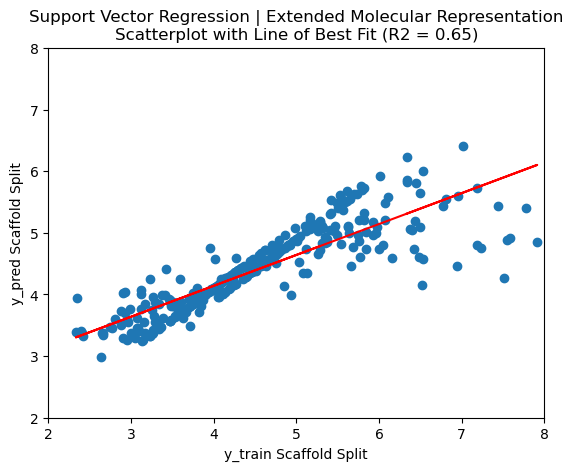

In [242]:
model = SVR(C=1, epsilon=0.1, kernel='rbf')
model.fit(x_train_scaffolds,y_train_scaffolds)
y_pred_train_scaffolds = model.predict(x_train_scaffolds)

# Root Mean Squared Error
mse = mean_squared_error(y_train_scaffolds, y_pred_train_scaffolds)
rmse = math.sqrt(mse)
print('root mean squared error is ', rmse)

# R2 berekenen
slope, intercept = nm.polyfit(y_train_scaffolds,y_pred_train_scaffolds,1)
line = slope * nm.array(y_train_scaffolds)+ intercept
r2 = r2_score(y_train_scaffolds, y_pred_train_scaffolds)
print('r2 is', r2)

# R2 Visualisatie
plt.scatter(y_train_scaffolds,y_pred_train_scaffolds)
plt.plot(y_train_scaffolds, line, color='red', label='line of current best fit')
plt.xlabel('y_train Scaffold Split')
plt.ylabel('y_pred Scaffold Split')
plt.xlim(2,8)
plt.ylim(2,8)
plt.title('Support Vector Regression | Extended Molecular Representation\nScatterplot with Line of Best Fit (R2 = {:.2f})'.format(r2))
plt.show()